In [ ]:
import torch
from config import batch_size, block_size, max_iters, eval_interval, learning_rate, eval_iters, n_embd, n_head, n_layer, dropout, sparsity, low_rank
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime
from loader_data import ShakespeareDataModule, ShakespeareDataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1337)



In [ ]:
6144/256

In [ ]:
from ebt_model import EBTransformerModel
from ebts_model import EBSTransformerModel

data_module = ShakespeareDataModule(data_dir="data/input.txt", batch_size=batch_size, block_size=block_size)
def_model = EBTransformerModel(data_module.vocab_size, n_embd, block_size, n_head, dropout, n_layer, learning_rate)
s_model = EBSTransformerModel(data_module.vocab_size, n_embd, block_size, n_head, dropout, n_layer, learning_rate, sparsity, low_rank)

# [64, 256]

In [ ]:
def test_sparse_inf(count, d_model, block_size, sparse, low_rank):
    if sparse:
        model = EBSTransformerModel(data_module.vocab_size, d_model, block_size, n_head, dropout, n_layer, learning_rate, sparse, low_rank)
    else:
        model = EBTransformerModel(data_module.vocab_size, d_model, block_size, n_head, dropout, n_layer, learning_rate)

    inputs = torch.randint(0, 65, [count, block_size])
    start = datetime.now()
    for e in inputs:
        model.predict_step(e.unsqueeze(0))
    time_s = datetime.now() - start
    return time_s, f"# {count}_d_model_{sparse}_{low_rank} : {time_s}"

In [70]:
b_d_model = 384
b_sparse = 24
token_c = 1
m_low = 1
# m_max = 9
# m_step = 0.5
m_max = 10
m_step = 0.5

count = 50



In [ ]:
timesa = [test_sparse_inf(count, int(e*b_d_model), token_c, None, None)[0].total_seconds()*1000/count for e in np.arange(m_low, m_max, m_step)]
timesb = [test_sparse_inf(count, int(e*b_d_model), token_c, int(int(e*b_d_model)*4/64), int(int(e*b_d_model)*4/64))[0].total_seconds()*1000/count for e in np.arange(m_low, m_max, m_step)]

In [65]:
import json
with open("exp_res/1_token/ex_data.json", "r") as f:
    r = json.load(f)

In [66]:
timesa = r["timea"]
timesb = r["timeb"]

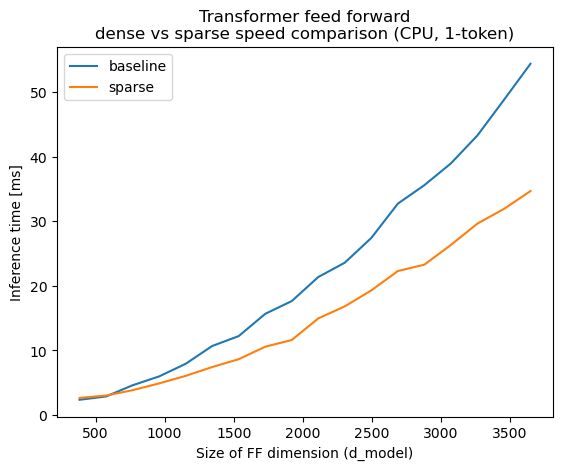

In [74]:
y = list([int(e*b_d_model) for e in np.arange(m_low, m_max, m_step)])
plt.plot(y, timesa, label="baseline")  # Plot the chart
plt.plot(y, timesb, label="sparse")  # Plot the chart
plt.xlabel("Size of FF dimension (d_model)")
plt.ylabel("Inference time [ms]")
plt.title("Transformer feed forward\ndense vs sparse speed comparison (CPU, 1-token)")
plt.legend()
plt.savefig("ex.png")
plt.show()

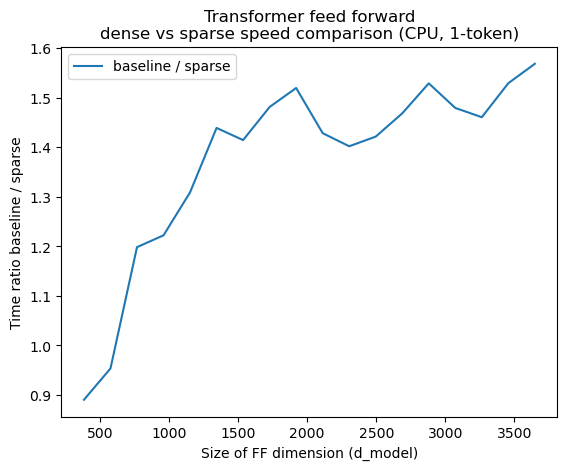

In [72]:

timec = [a/b for a, b in zip(timesa, timesb)]

plt.plot(y, timec, label="baseline / sparse")  # Plot the chart
plt.xlabel("Size of FF dimension (d_model)")
plt.ylabel("Time ratio baseline / sparse")
plt.title("Transformer feed forward\ndense vs sparse speed comparison (CPU, 1-token)")
plt.legend()
plt.savefig("ex_ratio.png")
plt.show()



In [ ]:

tos = {
    "timea":timesa,
    "timeb":timesb,
    "timec":timec
}

import json 

with open("data.json", "w") as f:
    json.dump(tos,f)

In [ ]:

# 100_d_model_24_24 : 0:00:06.844182
# 100_d_model_None_None : 0:00:02.474504
#  0.3615485385981846

# 10_d_model_24_24 : 0:00:00.660285
# 10_d_model_None_None : 0:00:00.236467
#  0.3581286868549187

# 10_d_model_48_48 : 0:00:02.022317
# 10_d_model_None_None : 0:00:00.632888
#  0.3129519259344603




